# Neumann Hamiltonian

We consider the integrable Hamiltonian

$$
H = \frac{1}{4}\sum_{\alpha,\beta} J_{\alpha\beta}^2 + \frac{1}{2}\sum_\alpha k_\alpha x_\alpha^2
$$

with $J_\alpha\beta = x_\alpha p_\beta - x_\beta p_\alpha$ is the (generalized) angular momentum. The constants of motion are

$$
I_\alpha = x_\alpha^2 + \sum_{\beta\neq \alpha} \frac{J_{\alpha\beta}^2}{k_\alpha-k_\beta}
$$

for $k_\alpha$ all different. We have

$$
H = \sum_\alpha k_\alpha I_\alpha
$$

And

$$
\sum_\alpha x_\alpha^2 = \sum_\alpha I_\alpha,
$$

so that motion is confined to the sphere $S^{N-1}$.

## Equations of Motion

The equations of motion have Hamiltonian form

$$
\begin{align}
\dot p_\alpha &= \frac{\partial H}{\partial x_\alpha} = -k_\alpha x_\alpha-\sum_\beta \left[x_\alpha p_\beta-x_\beta p_\alpha\right]p_\beta\\
\dot x_\alpha &= -\frac{\partial H}{\partial p_\alpha} = \sum_\beta \left[p_\alpha x_\beta-p_\beta x_\alpha\right]x_\beta
\end{align}
$$

## Sample solution in TF

In [1]:
import sys
sys.path.append("../")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

In [2]:
from hamiltonians import parameterized_neumann
from models import NICE, SymplecticExchange, SqueezeAndShift, Chain, MLP
from utils import visualize_chain_bijector_1d, compute_loss, compute_gradients, apply_gradients

../hamiltonians.py:28: DeprecationWarning: invalid escape sequence \s
  """1/4 \sum_{i,j}^N J_{ij}^2 + 1/2 \sum_{i=1}^N k_i q_i^2"""
../hamiltonians.py:39: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:47: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:56: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:65: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:74: DeprecationWarning: invalid escape sequence \s
  """
../hamiltonians.py:83: DeprecationWarning: invalid escape sequence \s
  """


In [3]:
tf.enable_eager_execution()
tf.set_random_seed(0)

In [4]:
N = 3 
ks = np.random.rand(N)

In [5]:
def neumann_equations(phase_space_point, t):
    xs, ps = tf.split(phase_space_point, num_or_size_splits=2)
    dps = - ks * xs
    dps += -xs * tf.reduce_sum(ps**2)
    dps += ps * tf.reduce_sum(xs * ps)
    dxs = ps * tf.reduce_sum(xs**2)
    dxs += - xs * tf.reduce_sum(xs * ps)
    return tf.concat([dxs, dps], axis=0)

In [6]:
init_state = tf.constant(np.random.rand(2*N), dtype=tf.float64)
t = np.linspace(0, 100, num=5000)
tensor_state, tensor_info = tf.contrib.integrate.odeint(
    neumann_equations, init_state, t, full_output=True)

state = tensor_state.numpy()
x, y, z, px, py, pz = state.T

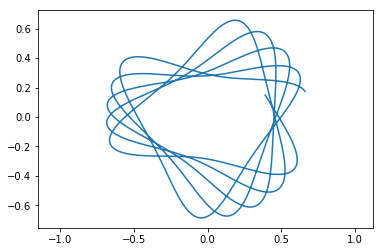

In [7]:
plt.axes().set_aspect('equal', 'datalim')
plt.plot(x, y)

## Check the integrals of motion

In [8]:
def Is(phase_space_point):
    xs, ps = np.split(phase_space_point, indices_or_sections=2)
    Is = xs**2 
    for α, _ in enumerate(Is):
        for β, _ in enumerate(Is):
            J = xs[α]*ps[β] - ps[α]*xs[β]
            if β != α:
                Is[α] += J**2 / (ks[α] - ks[β])
    return Is

In [9]:
I_traj = np.array([Is(point) for point in state])

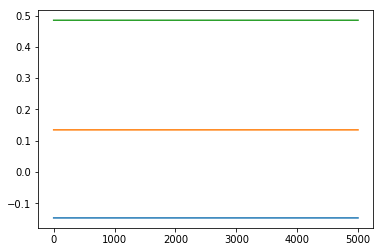

In [10]:
plt.plot(I_traj)

The Neumann Hamiltonian

In [11]:
neumann_hamiltonian = parameterized_neumann(ks)

In [29]:
test = tf.random_uniform([1,3,1])

In [30]:
test[0,:,0]

<tf.Tensor: id=320271, shape=(3,), dtype=float32, numpy=array([0.05311072, 0.18923342, 0.97226834], dtype=float32)>

In [33]:
tf.transpose?

In [32]:
tf.split?

In [12]:
neumann_hamiltonian(tf.reshape(init_state, (1,-1,1)))

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

## Learning a Transformation

In [11]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [12]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': parameterized_neumann(ks), 
    'phase_space_dim': 2*N, 
    'batch_size': 256,    # Mini batch size 
    'num_bijectors': 4,   # Number of bijectors
    'train_iters': 1e5}   # Number of training iterations

In [13]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([settings['phase_space_dim']], DTYPE))

In [14]:
bijectors = [SqueezeAndShift(shift_model=MLP(return_gradient=True,activation=tf.tanh)) if i % 2 == 0 
             else SymplecticExchange() 
             for i in range(settings['num_bijectors'])]
model = Chain(bijectors)

Training

In [15]:
import time
start_time = time.time()

optimizer = tf.train.AdamOptimizer(1e-4)

# TODO: implement early stopping? / decrease learning rate over time

global_step = []
losses = []
gradients_norms = []
for epoch in range(int(1e4)):
    z_samples = tf.expand_dims(base_dist.sample(settings['batch_size']),-1)
    gradients, loss = compute_gradients(model, settings['hamiltonian'], z_samples)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    # Visualization
    if epoch % 1e2 == 0:
        global_step.append(epoch)
        losses.append(loss.numpy())
        gradients_norms.append([tf.norm(gradients[i]).numpy() for i in range(len(gradients))])        
    if epoch % int(1e4) == 0:
        print(epoch, loss.numpy())
end_time = time.time()
print("Time elapsed: ", end_time - start_time)

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'